When you train a deep neural network, you essentially start with the default representation of the data (for example, images are represented as 3-D arrays), and applies a series of transformations (Conv, relu, pooling, fully connected, etc.), each of which changes the data representation. 

Deep neural network is known for the ability to automatically search for the set of learnable parameters which gives the "best" representation of the data, which makes the discrminating/classifying much easier than using the original default features.

Here we visualize the transformed represenation of the handwritten digits in 2-D space by appling TSNE. 

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.manifold import TSNE

from autodiff import *

%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

batch = 50
iterations = 500 

sess = Session()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Define and train the network

In [2]:
X = PlaceholderOp((batch, 28, 28, 1), sess, False)
Y_ = PlaceholderOp((batch, 10), sess, False)
P = PlaceholderOp((), sess, False)
W_CONV1 = PlaceholderOp((5, 5, 1, 32), sess)
B_CONV1 = PlaceholderOp((32,), sess)
W_CONV2 = PlaceholderOp((5, 5, 32, 64), sess)
B_CONV2 = PlaceholderOp((64,), sess)
W_FC1 = PlaceholderOp((7 * 7 * 64, 1024), sess)
B_FC1 = PlaceholderOp((1024,), sess)
W_FC2 = PlaceholderOp((1024, 10), sess)
B_FC2 = PlaceholderOp((10,), sess)

CONV1 = Conv2dOp(X, W_CONV1, [1, 1], "SAME", sess)
CONV1_B = BiasAddOp(CONV1, B_CONV1, sess)
H_CONV1 = ReluOp(CONV1_B, sess)
H_POOL1 = MaxPool2dOp(H_CONV1, [2, 2], [2, 2], "SAME", sess)
CONV2 = Conv2dOp(H_POOL1, W_CONV2, [1, 1], "SAME", sess)
CONV2_B = BiasAddOp(CONV2, B_CONV2, sess)
H_CONV2 = ReluOp(CONV2_B, sess)
H_POOL2 = MaxPool2dOp(H_CONV2, [2, 2], [2, 2], "SAME", sess)
H_POOL2_FLAT = ReshapeOp(H_POOL2, (batch, 7 * 7 * 64), sess)
FC1 = MatMulOp(H_POOL2_FLAT, W_FC1, sess)
FC1_B = BiasAddOp(FC1, B_FC1, sess)
H_FC1 = ReluOp(FC1_B, sess)
H_FC1_DROP = DropoutOp(H_FC1, P, sess)
FC2 = MatMulOp(H_FC1_DROP, W_FC2, sess)
Y_CONV = BiasAddOp(FC2, B_FC2, sess)
SOFTMAX = SoftmaxCrossEntropyWithLogitsOp(Y_, Y_CONV, sess)
CROSS_ENTROPY = ReduceMeanOp(SOFTMAX, 0, sess)

w_conv1 = np.random.normal(scale=0.1, size=W_CONV1.shape)
b_conv1 = np.ones(B_CONV1.shape) * 0.1
w_conv2 = np.random.normal(scale=0.1, size=W_CONV2.shape)
b_conv2 = np.ones(B_CONV2.shape) * 0.1
w_fc1 = np.random.normal(scale=0.1, size=W_FC1.shape)
b_fc1 = np.ones(B_FC1.shape) * 0.1
w_fc2 = np.random.normal(scale=0.1, size=W_FC2.shape)
b_fc2 = np.ones(B_FC2.shape) * 0.1

feed_dict = { W_CONV1: w_conv1,
              B_CONV1: b_conv1,
              W_CONV2: w_conv2,
              B_CONV2: b_conv2,
              W_FC1: w_fc1,
              B_FC1: b_fc1,
              W_FC2: w_fc2,
              B_FC2: b_fc2}

params = {"alpha":  1e-3,
          "beta1":  .9,
          "beta2":  .999,
          "epsilon":  1e-8,
          "t":  0,
          "m":  { W_CONV1: np.zeros_like(w_conv1),
                  B_CONV1: np.zeros_like(b_conv1),
                  W_CONV2: np.zeros_like(w_conv2),
                  B_CONV2: np.zeros_like(b_conv2),
                  W_FC1: np.zeros_like(w_fc1),
                  B_FC1: np.zeros_like(b_fc1),
                  W_FC2: np.zeros_like(w_fc2),
                  B_FC2: np.zeros_like(b_fc2)},
          "v":  { W_CONV1: np.zeros_like(w_conv1),
                  B_CONV1: np.zeros_like(b_conv1),
                  W_CONV2: np.zeros_like(w_conv2),
                  B_CONV2: np.zeros_like(b_conv2),
                  W_FC1: np.zeros_like(w_fc1),
                  B_FC1: np.zeros_like(b_fc1),
                  W_FC2: np.zeros_like(w_fc2),
                  B_FC2: np.zeros_like(b_fc2)}}

for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch)

    feed_dict[X] = batch_xs.reshape((batch, 28, 28, 1))
    feed_dict[Y_] = batch_ys
    feed_dict[P] = .5

    if i % 50 == 0:
        Y_CONV_val = sess.eval_tensor(Y_CONV, feed_dict)
        CROSS_ENTROPY_val = sess.eval_tensor(CROSS_ENTROPY, feed_dict)
        print "iteration: %d, train accuracy: %f, loss: %f" % (i, np.mean(np.argmax(Y_CONV_val, axis=1) ==
                                                                      np.argmax(batch_ys, axis=1)), 
                                                           CROSS_ENTROPY_val)

    sess.adam_update(params, CROSS_ENTROPY, feed_dict)

iteration: 0, train accuracy: 0.100000, loss: 18.909420
iteration: 50, train accuracy: 0.860000, loss: 0.821727
iteration: 100, train accuracy: 0.860000, loss: 0.536153
iteration: 150, train accuracy: 0.940000, loss: 0.280461
iteration: 200, train accuracy: 0.960000, loss: 0.234686
iteration: 250, train accuracy: 0.960000, loss: 0.107247
iteration: 300, train accuracy: 0.920000, loss: 0.273291
iteration: 350, train accuracy: 0.940000, loss: 0.149329
iteration: 400, train accuracy: 0.840000, loss: 0.265965
iteration: 450, train accuracy: 0.940000, loss: 0.163440


Record the re-representated images (1024-D vectors) from the 1st FC layer, plot them in 2-D space by applying t-SNE. Digits in different classes are colored differently.

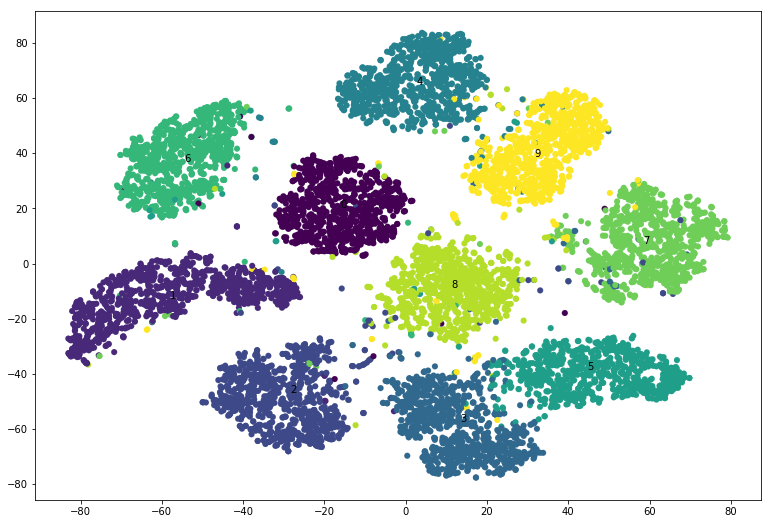

In [3]:
import matplotlib

embeddings = []
for i in range(0, mnist.test.images.shape[0], batch):
    feed_dict[X] = mnist.test.images[i : i + batch].reshape((batch, 28, 28, 1))
    feed_dict[P] = 1.
    H_FC1_DROP_val = sess.eval_tensor(H_FC1_DROP, feed_dict)
    embeddings.append(H_FC1_DROP_val)
    
embeddings = np.vstack(embeddings)
y_true = mnist.test.labels.argmax(axis=1)

tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(embeddings)
plt.scatter(x=embedding_2d[:, 0], y=embedding_2d[:, 1], c=y_true, linewidths=0.1)    

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(13, 9)

for i in xrange(10):
    x, y = embedding_2d[y_true == i, :].mean(axis=0)
    plt.text(x, y, str(i))

The original handwritten digits are represented as `28 x 28 x 1` 3-D arrays (or equivalently 784-D vectors), while in the 1st FC layer they are re-represented as 1024-D vectors, which are the input to the final readout layer (which is a simple linear transformation without nonlinearity).

Clearly, handwritten digits in same classes are much closer than those from a different class. 